In [1]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-d38b3e5c-cec9-14ba-7c4d-83f56997f76a)


In [2]:
import os
import re
import json
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from datasets import load_dataset
from transformers import (
    PaliGemmaForConditionalGeneration,
    PaliGemmaProcessor,
    AutoModel,
    TrainingArguments,
    SiglipModel,
    Trainer
)
from transformers import TrainerCallback
from huggingface_hub import HfApi

In [3]:
COLORS = {
    'central_incisor': '#FF0000', 'lateral_incisor': '#FF4500',
    'canine': '#0000FF', 'first_premolar': '#008000',
    'second_premolar': '#32CD32', 'first_molar': '#800080',
    'second_molar': '#FF00FF', 'third_molar': '#8B4513',
    'incisor': '#FF6347', 'premolar': '#3CB371',
    'molar': '#9370DB', 'tooth': '#696969',
}

def visualize_side_by_side(dataset, indices=[0, 1], show_predictions=None, processor=None, model=None):
    n = len(indices)

    if show_predictions == 'gt_only':
        fig, axes = plt.subplots(1, n, figsize=(12*n, 7))
        axes = [axes] if n == 1 else axes

        for idx, sample_idx in enumerate(indices):
            sample = dataset[sample_idx]
            gt_img, gt_count = draw_boxes(sample['image'], sample['target'])
            axes[idx].imshow(gt_img)
            axes[idx].set_title(f"GT {sample_idx} - {gt_count} boxes")
            axes[idx].axis('off')

    elif show_predictions == 'both':
        fig, axes = plt.subplots(n, 2, figsize=(24, 7*n))
        if n == 1:
            axes = [axes]

        for idx, sample_idx in enumerate(indices):
            sample = dataset[sample_idx]

            gt_img, gt_count = draw_boxes(sample['image'], sample['target'])
            axes[idx][0].imshow(gt_img)
            axes[idx][0].set_title(f"GT {sample_idx} - {gt_count} boxes")
            axes[idx][0].axis('off')

            inputs = processor(text="<image><bos>" + sample['prompt'], images=sample['image'], return_tensors="pt").to(model.device)
            with torch.no_grad():
                pred_text = processor.decode(model.generate(**inputs, max_new_tokens=256)[0], skip_special_tokens=False)
            pred_img, pred_count = draw_boxes(sample['image'], pred_text)
            axes[idx][1].imshow(pred_img)
            axes[idx][1].set_title(f"Pred {sample_idx} - {pred_count} boxes")
            axes[idx][1].axis('off')

    plt.tight_layout()
    plt.show()

def draw_boxes(image, target_text):
    """Draw boxes and return image + count. Skips invalid boxes."""
    img = image.copy()
    draw = ImageDraw.Draw(img)
    matches = list(re.finditer(r'<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})> (\w+(?: \w+)*)', target_text))
    valid_boxes = 0

    for match in matches:
        y1, x1, y2, x2, label = match.groups()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # Skip invalid boxes
        if x2 <= x1 or y2 <= y1:
            continue

        color = COLORS.get(label.replace(' ', '_'), '#%06x' % random.randint(0, 0xFFFFFF))
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        draw.text((x1, y1-15), label, fill=color)
        valid_boxes += 1

    return img, valid_boxes

In [4]:
dataset = load_dataset("justacoderwhocodes/dental_iopar_panoramic_coarse_dataset", split="train")

In [5]:
dataset = dataset.shuffle(seed=42)

In [6]:
dataset[0]['prompt']

'detect canine; detect incisor; detect molar; detect premolar;'

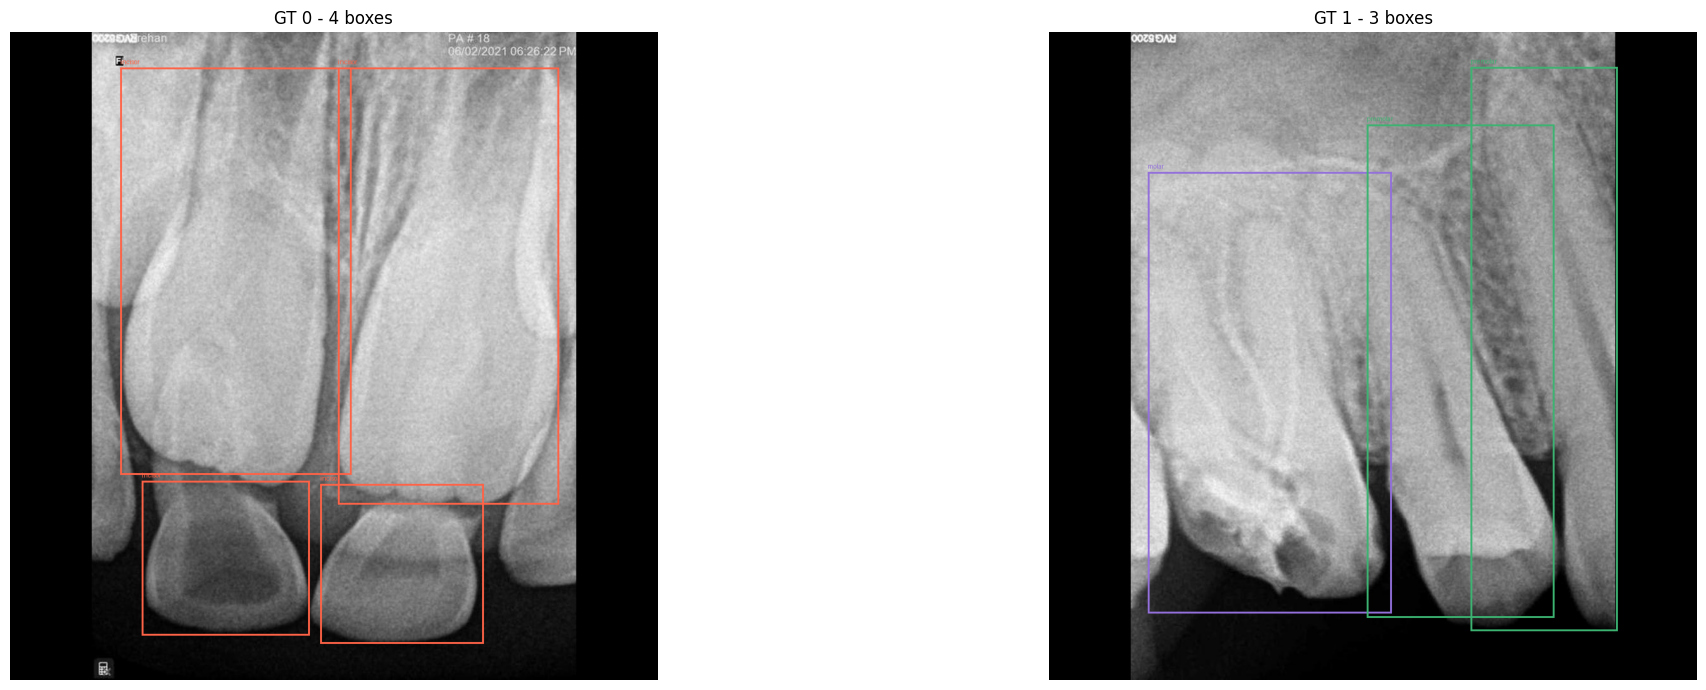

In [7]:
visualize_side_by_side(dataset, indices=[0, 1], show_predictions='gt_only')

In [ ]:
processor = PaliGemmaProcessor.from_pretrained("google/paligemma-3b-pt-448")
model = PaliGemmaForConditionalGeneration.from_pretrained("google/paligemma-3b-pt-448", torch_dtype=torch.bfloat16, device_map="auto")
medsiglip = SiglipModel.from_pretrained("google/medsiglip-448",dtype=torch.bfloat16)

The image processor of type `SiglipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/603 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/888 [00:00<?, ?it/s]

Now to freeze the vision encoder and train remaining params

In [9]:
medsiglip_state_dict = medsiglip.vision_model.state_dict()

In [10]:
[key for key in medsiglip_state_dict.keys() if 'head' in key] #let's remove these while loading since the head is now PaliGemma

['head.probe',
 'head.attention.in_proj_weight',
 'head.attention.in_proj_bias',
 'head.attention.out_proj.weight',
 'head.attention.out_proj.bias',
 'head.layernorm.weight',
 'head.layernorm.bias',
 'head.mlp.fc1.weight',
 'head.mlp.fc1.bias',
 'head.mlp.fc2.weight',
 'head.mlp.fc2.bias']

In [ ]:
filtered_state_dict_no_head = {
    k: v for k, v in medsiglip_state_dict.items()
    if not k.startswith("head.")
}

In [ ]:
model.model.vision_tower.vision_model.load_state_dict(filtered_state_dict_no_head, strict=True)

In [13]:
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,} params")

Total parameters: 2,924,351,216 params


In [14]:
# for param in model.model.vision_tower.vision_model.parameters():
#     param.requires_grad = False
print(f"Vision frozen: {sum(p.numel() for p in model.model.vision_tower.vision_model.parameters() if not p.requires_grad):,} params")
print(f"Total trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,} params")

Vision frozen: 0 params
Total trainable: 2,924,351,216 params


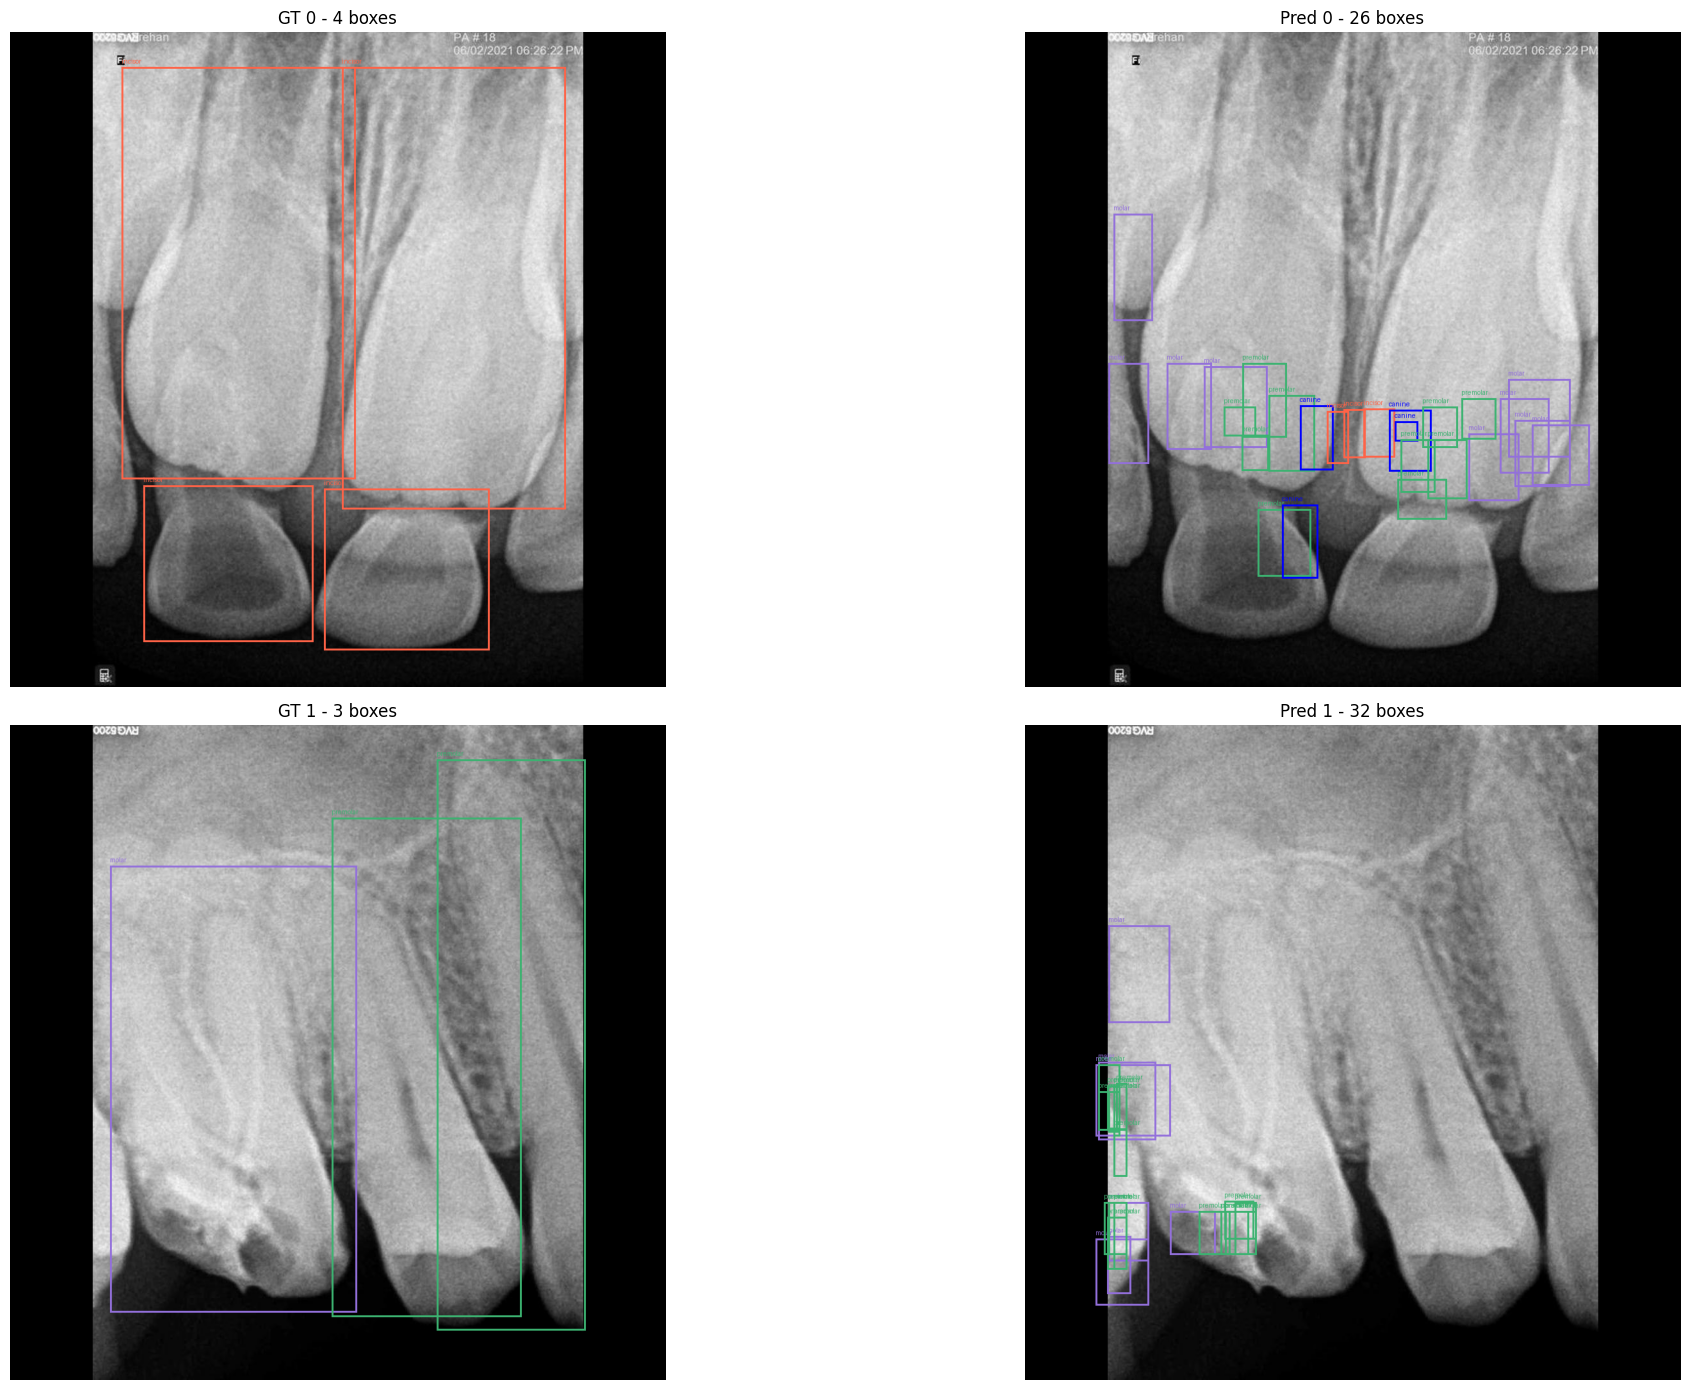

In [15]:
visualize_side_by_side(dataset, indices=[0, 1], show_predictions='both', processor=processor, model=model)

Now to train

In [16]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [17]:
target_field = 'target' #Default fine grained targets -> use target_group or target_fallbackevery_n_steps
every_n_steps = 200
logging_steps = 10

In [18]:
class TrainVizCallback(TrainerCallback):
    def __init__(self, dataset, processor, every_n_steps=100):
        self.dataset = dataset
        self.processor = processor
        self.every_n_steps = every_n_steps
        self.sample_indices = [0, len(dataset)//2, len(dataset)-1]
        self.api = HfApi()

    def on_step_end(self, args, state, control, model=None, **kwargs):
        if state.global_step % self.every_n_steps == 0:
            model.eval()
            visualize_side_by_side(
                self.dataset,
                indices=self.sample_indices,
                show_predictions='both',
                processor=self.processor,
                model=model
            )
            model.train()


class DentalDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, processor):
        self.dataset = hf_dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        inputs = self.processor(
            text="<image><bos>" + item['prompt'],
            images=item['image'],
            suffix=item[target_field],  # This is the target/label
            return_tensors="pt",
            truncation=True,
            max_length=2048,
            padding="max_length"
        )

        return {k: v.squeeze(0) for k, v in inputs.items()}

In [19]:
def collate_fn(features):
    import torch
    from torch.nn.utils.rnn import pad_sequence

    batch = {}

    for key in features[0].keys():
        if key == 'labels':
            labels = [f[key] for f in features]
            batch[key] = pad_sequence(labels, batch_first=True, padding_value=-100)
        elif isinstance(features[0][key], torch.Tensor):
            if key in ['pixel_values', 'pixel_attention_mask']:
                batch[key] = torch.stack([f[key] for f in features])
            else:
                sequences = [f[key] for f in features]
                batch[key] = pad_sequence(sequences, batch_first=True, padding_value=0)
        else:
            batch[key] = [f[key] for f in features]

    return batch

In [20]:
train_test_split = dataset.train_test_split(test_size=0.05, seed=42)
train_dataset_hf = train_test_split['train']
eval_dataset_hf = train_test_split['test']

In [21]:
train_dataset = DentalDataset(train_dataset_hf, processor)
eval_dataset = DentalDataset(eval_dataset_hf, processor)

In [22]:
print(len(train_dataset),len(eval_dataset))

482 26


In [23]:
args = TrainingArguments(
    output_dir="./paligemma-dental-448",
    num_train_epochs=20,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    warmup_steps=50,
    lr_scheduler_type="cosine",
    logging_steps=logging_steps,
    save_steps=500,
    push_to_hub=True,
    hub_model_id="justacoderwhocodes/paligemma-dental-bounding-boxes",
    bf16=True,
    eval_steps=100
)

In [24]:
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[TrainVizCallback(eval_dataset_hf, processor, every_n_steps=every_n_steps)]
)

In [ ]:
trainer.train()

Step,Training Loss
10,2.487577
20,2.277830
30,2.307379


In [ ]:
dataset = dataset.shuffle()
visualize_side_by_side(dataset, indices=[0, 1], show_predictions='both', processor=processor, model=model)

In [ ]:
trainer.push_to_hub()